# Prevendo vendas com Arima
+ *Método estatístico* para Previsão de *séries temporais* utilizando autoregressão e médias móveis.
+ O ARIMA depende de uma boa autocorrelação

In [1]:
import pandas as pd
champagne = pd.read_csv('champagne_sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

In [2]:
# Elinar warnings das bigliotecas
import warnings
warnings.filterwarnings("ignore")

In [3]:
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt

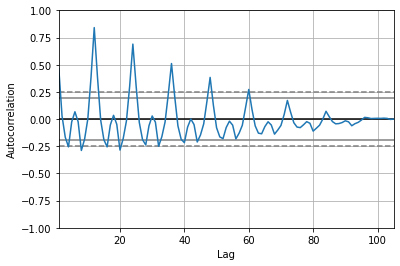

In [4]:
# autocorrelation plot - Plota autocorrelação entre os dados da série "champagne"
autocorrelation_plot(champagne)
plt.show()

+ O gráfico acima mostra que os dados mais recentes são melhor correlacionados

In [5]:
# outra forma de plotar a autocorrelação
# pip install statsmodels
import pandas.util.testing as tm
from statsmodels.graphics.tsaplots import plot_acf # plot de autocorrelação
from statsmodels.graphics.tsaplots import plot_pacf # parcial correlation plot

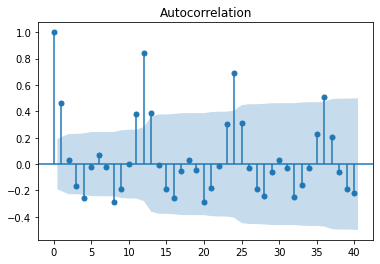

In [6]:
plot_acf(champagne, lags=40) # lags = quantidade de lags anteriores que irei ver.
plt.show()
# parte azul do gráfico mostra os níveis de significancia da correlação

+ até o nível 7 aproximadamente, temos lags bem autocorrelacionados no gráfico acima

In [7]:
# fit model
from statsmodels.tsa.arima_model import ARIMA

In [8]:
# Configurando o método arima
# ARIMA(p,d,q)
model = ARIMA(champagne, order=(7,1,1))

/home/hildebrando/projetos Ciência de dados/ETL/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/hildebrando/projetos Ciência de dados/ETL/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [9]:
# rodando o modelo
model_fit = model.fit()

In [10]:
# resumo
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:      D.Champagne sales   No. Observations:                  104
Model:                 ARIMA(7, 1, 1)   Log Likelihood                -938.828
Method:                       css-mle   S.D. of innovations           1954.371
Date:                Wed, 30 Jun 2021   AIC                           1897.655
Time:                        08:53:20   BIC                           1924.099
Sample:                    02-01-1964   HQIC                          1908.369
                         - 09-01-1972                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      23.8413      5.224      4.564      0.000      13.603      34.079
ar.L1.D.Champagne sales     0.4881      0.096      5.096      0.000       0.300       0.676


In [11]:
# Verificando os residuais - Erros entre o valor real e o valor predito
from pandas import DataFrame
residuals = DataFrame(model_fit.resid)

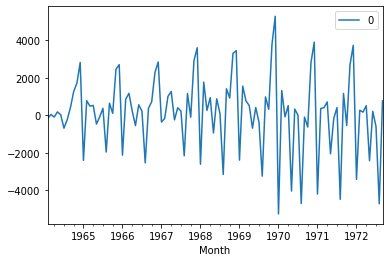

In [12]:
residuals.plot()
plt.show()

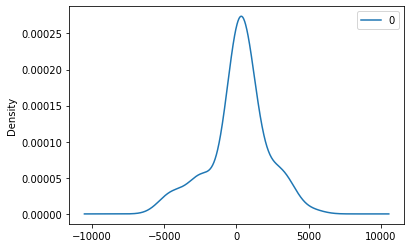

In [13]:
# gráficos de densidade dos residuais
residuals.plot(kind='kde')
plt.show()

In [14]:
# estatistica descrivida dos resíduos
print(residuals.describe())

                 0
count   104.000000
mean    157.059643
std    1981.387597
min   -5258.559700
25%    -388.872377
50%     327.207001
75%     988.679715
max    5283.466477


# Prevendo dados com ARIMA utilizando **Walk Forward**
## Separando dados de treino e teste

In [15]:
# Guardando os dados da série champagne em X
X = champagne.values
X = X.astype('float32')

In [16]:
# Separando dos dados com 50% treono e 50% teste
size = int(len(X) * 0.5)

In [17]:
# Separando dados de treino e teste
train = X[0:size] # do ídice Zero ao tamanho de size
test  = X[size:]  # de size até o final

In [18]:
# Criando variável history para fazer controle dos dados
# É uma variável controle para fazer o Walk Forward
history = [x for x in train]

In [19]:
predictions = list()

In [20]:
# Função que faz a diferenciação dos dados do mês com os dados do mesmo mês no ano anterior.
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff


# Função que reverte o valor diferenciado para o valor original.
# Isto serve para ver se o modelo está entregando ótimos resultados
def inverse_difference(history, previsao, interval=1):
    return previsao + history[-interval]

In [21]:
# inicia o Walk-Forward
for t in range(len(test)):
    # trabalhando com diferenciação de 12 meses
    meses_no_ano = 12
    diff = difference(history, meses_no_ano)
    
    # cria um modelo ARIMA com os dados de history
    model = ARIMA(diff, order=(1,1,1))
    
    # treina o modelo ARIMA
    model_fit = model.fit(trend='nc', disp=0) # estes dois parâmetros são sugeridos pela biblioteca 
    
    # a variável valor_predito recebe o valor previsto pelo modelo
    valor_predito = model_fit.forecast()[0]
    
    # valor_predito recebe o valor revertido (escala original)
    valor_predito = inverse_difference(history, valor_predito, meses_no_ano)
    
    # adiciona o valor predito a lista de predições
    predictions.append(valor_predito)
    
    # a variável valor_real recebe o valor real do teste
    valor_real = test[t]
    
    # adiciona o valor real a variável history
    history.append(valor_real)
    
    # imprime valor predito e valor real
    # print(f"Valor predito = {valor_predito}, valor esperado = {valor_real}")
    # print(f"Valor predito = {valor_predito:.2f}, valor esperado = {valor_real:.2f}")
    print("Valor predito = %.2f, valor esperado = %.2f" % (valor_predito, valor_real))

Valor predito = 5156.50, valor esperado = 4647.00
Valor predito = 5046.67, valor esperado = 4753.00
Valor predito = 4143.85, valor esperado = 3965.00
Valor predito = 2102.96, valor esperado = 1723.00
Valor predito = 5228.27, valor esperado = 5048.00
Valor predito = 5873.37, valor esperado = 6922.00
Valor predito = 8571.26, valor esperado = 9858.00
Valor predito = 11006.16, valor esperado = 11331.00
Valor predito = 4087.49, valor esperado = 4016.00
Valor predito = 4771.84, valor esperado = 3957.00
Valor predito = 4676.11, valor esperado = 4510.00
Valor predito = 4583.39, valor esperado = 4276.00
Valor predito = 5117.35, valor esperado = 4968.00
Valor predito = 5208.15, valor esperado = 4677.00
Valor predito = 4436.43, valor esperado = 3523.00
Valor predito = 2181.00, valor esperado = 1821.00
Valor predito = 5471.25, valor esperado = 5222.00
Valor predito = 7337.57, valor esperado = 6872.00
Valor predito = 10268.43, valor esperado = 10803.00
Valor predito = 11725.32, valor esperado = 139

In [22]:
# Avaliando os resultados
from numpy import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(test, predictions))
print("Test RMSE: {rmse:.3f}")

Test RMSE: {rmse:.3f}


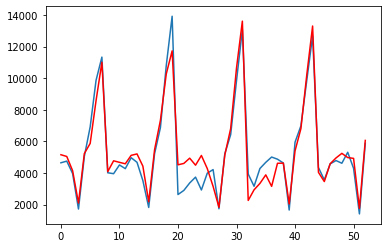

In [23]:
# plot forecasts against actual outcomes
plt.plot(test) # valores reais
plt.plot(predictions, color='red') # valores preditos
plt.show()

## verificando os resíduos para ver se o modelo pode ser melhorado
+ ***Erros residuais são erros em previsão de séries temporais.*** 
    * Tendencias 
    * Sazonalidades
+ Erro residual =  Valor esperado - Valor predito

In [24]:
# erros residuais
residuals = [test[i] - predictions[i] for i in range(len(test))]

In [27]:
# converte a lista em um dataframe
residuals = pd.DataFrame(residuals)

In [28]:
residuals.head()

,0
0,-509.504165
1,-293.674683
2,-178.848052
3,-379.961505
4,-180.265141


In [29]:
# estatística descritiva
residuals.describe()

,0
count,53.000000
mean,-100.880531
std,842.171665
min,-2182.009149
25%,-509.504165
50%,-180.265141
75%,258.918967
max,2190.683757


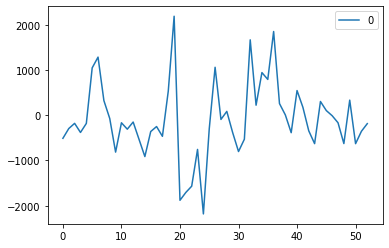

In [30]:
# plot residuals
residuals.plot()
plt.show()

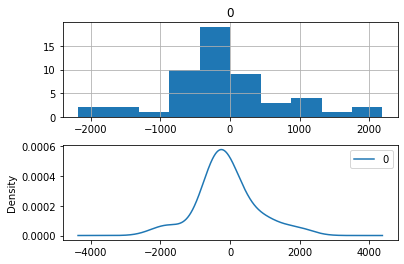

In [34]:
# plots histograma
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca(), bins=10)

plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

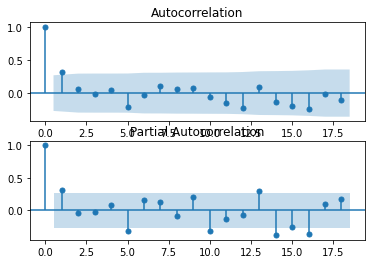

In [36]:
# plots de autocorrelação
plt.figure()
plt.subplot(211)
plot_acf(residuals, ax=plt.gca())

plt.subplot(212)
plot_pacf(residuals, ax=plt.gca())

plt.show()